# Соревнование: San Francisco Crime Classification
*Given time and location, you must predict the category of crime that occurred. Kaggle is hosting this competition for the machine learning community to use for fun and practice.*

https://www.kaggle.com/c/sf-crime

Этот ноутбук структурирован таким образом, чтобы облегчить совместную работу над соревнованием. За некоторыми исключениями, каждый участник работает только в разделе 4. При этом ни одна из строк кода любого из разделов не является постоянной, если в ней нет необходимости, ее стоит исключить, если один из участников написал полезный код, который может пригодится остальным, то этот когда имеет смысл перенести из персонального раздела в общие. Ноутбук имеет следующую структуру:
1. Подготовка работы. Загрузка библиотек и настройка отображения
+ Загрузка и очистка данных
+ Общие функции
+ Персональный раздел
+ Модель на тестовой выборке 

### 1. Подготовка работы. Загрузка библиотек и настройка отображения
Импорты и настроийки, которые необходимы для шаблона.

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
import time
import datetime
import csv
import cPickle

%matplotlib inline

### 3. Общие функции
Это функции для операций с данными.
Сюда надо написать функции для записи моделей и их параметров в файл (хранить в json?), и пр.

In [4]:
# добавление колонок к выборке
# хорошо бы сделать, чтоб работало для разных типов
def add_features_to_X(X, X_add):
    assert X.shape[0] == X_add.shape[0]
    X_add.index = X.index
    return pd.concat([X, X_add], axis=1, join_axes=[X.index])

# расп-сить колонку y.Category в матрицу с колонками out_features
def y_to_dummy(y):
    out = pd.get_dummies(( y ).tolist()+out_features)
    return out.head(len(y))

# приводим типы колонок первоначальной выборки в порядок
def typify_origin(data):
    data['Dates'] = pd.to_datetime(data['Dates'])
    categorycal_cols = ['Category', 'Descript', 'DayOfWeek', 'PdDistrict',
                        'Resolution', 'Address']
    for category in categorycal_cols:
        if category in data:
            data[category] = data[category].astype('category')    
    return data


# для работы с усеченной выборкой
# ограничиваем выборку 2009 и 2010 годами ;(
def cut_data(data):
    if 'year' not in data.columns:
        data = add_year(data)
    data = data[(data.year == 2009) | (data.year == 2010)]
    return data

## -- добавляем признаки --
# год
def add_year(data):
    data['year'] = data['Dates'].dt.year
    return data
# квартал (3 месяца)
def add_quarter(data):
    data['quarter'] = data['Dates'].dt.quarter
    return data
# месяц
def add_month(data):
    data['month'] = data['Dates'].dt.month
    return data
# час
def add_hour(data):
    data['hour'] = data['Dates'].dt.hour
    return data
# минуты
def add_minute(data):
    data['minute'] = data['Dates'].dt.minute
    return data
# бинарные дни недели
def day_to_dummy(days):    
    out = pd.get_dummies(( days ).tolist()+day_features)
    return out.head(len(days))
def add_dummy_days(X):
    X_add = day_to_dummy(X.DayOfWeek)
    X = add_features_to_X(X, X_add)
    return X

In [5]:
# проститутская синусоида
def add_whoresin(data):
    data['whoresin'] = map(math.cos, (data.hour + 3.3)/math.pi/1.35)
#     data['whoresin'] = data['hour'].apply(lambda x: np.sin(-np.pi/12. * (x - 4))) #alexey_kozulin
    return data

def add_hour_0_12(data):
    data['hour_0_12'] = data['hour'].apply(lambda x: 1 if (x==12)|(x==0) else 0)
    return data

def add_minute_0_30(data):
    data['minute_0_30'] = data['minute'].apply(lambda x: 1 if (x==30)|(x==0) else 0)
    return data

def add_minute_15_45(data):
    data['minute_15_45'] = data['minute'].apply(lambda x: 1 if (x==15)|(x==45) else 0)
    return data

def add_minute_01(data):
    data['minute_01'] = data['minute'].apply(lambda x: 1 if (x==1) else 0)
    return data

def add_minute_x05(data):
    data['minute_x05'] = data['minute'].apply(lambda x: 1 if (x==5)|(x==10)|(x==20)|(x==25)|
                                                (x==35)|(x==40)|(x==50)|(x==55) else 0)
    return data

# улицы и углы улич
# by @movb
def get_streets(street):
    if street.find('/') != -1:
        return map(str.strip, street.split('/'))
    pos = street.find('Block of ')
    if pos != -1:        
        return [street[pos+9:]]    
    return [street]
# by @movb
def is_corner(addr):
    streets = get_streets(addr)
    if len(list(streets))>1:
        return 1
    return 0
def add_corner(data):
    data['corner'] = map(is_corner, data.Address)
    return data

### 2. Загрузка, очистка данных. Общие константы
Обучающая и тренировочная выборки надоходятся в папке `data`. 

In [6]:
train = typify_origin(pd.read_csv('./data/train.csv'))
# работаем с усеченной выборкой
# train = cut_data(train)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null category
Descript      878049 non-null category
DayOfWeek     878049 non-null category
PdDistrict    878049 non-null category
Resolution    878049 non-null category
Address       878049 non-null category
X             878049 non-null float64
Y             878049 non-null float64
dtypes: category(6), datetime64[ns](1), float64(2)
memory usage: 33.7 MB


#### 2.1. Очистка данных
В то время, как в `train` находятся сырые данные, `X_train` содержит те же колонки, что и `test`, поэтому многие преобразования над обеими переменными могут выполняться одной функцией.

In [7]:
# необходимо принять волевое решение, что делать с данными у которых левые координаты?
# пока их исключаем
train = train[train.Y < 40]

# чтобы не было ворнингов о том, что это усеченный датафрейм
# train.is_copy = False

# целевая переменная, не путать с координатой
y = train.Category

In [8]:
# эти колонки содержатся в тестовой выборке
test_features = pd.read_csv('./data/test.csv', nrows=1, index_col='Id').columns.tolist()

# список происшествий, колонки для файла с результатами 
out_features = pd.read_csv('./data/sampleSubmission.csv', nrows=1, index_col='Id').columns.tolist()

# количество классов происшествий
classes = len(out_features)

# дни недели
day_features = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

#### 2.2. Общие константы
Константы, которые используются для обработки данных.

In [12]:
# данные
train_rows = train.shape[0]
train_features = train.columns.tolist()
test_features = pd.read_csv('./data/test.csv', nrows=1, index_col='Id').columns.tolist()

# другие
random_state = 19

#### 4. Персональный раздел. 
Место для творчества. В этом пункте можно творить что угодно! 

Возможно, стоит указывать свой `id` для наиболее полезных функций и т.п.

В конце раздела передаем свой классификатор в переменную `clf`

#### 4.1. Мои импорты

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.cross_validation import train_test_split

#### 4.2. Мои константы
Все мои клевые константы находятся здесь.

#### 4.3. Мои функции
Мои потрясающие функции определены в следующих ячейках.

In [10]:
# считает количество преступлений в y
# если заданы правильные ответы y_true, то считает количество правильно определенных преступлений
def count_crimes(y, y_true = 0):
    cond = type(y_true) != type(0)
    if cond:
        assert len(y) == len(y_true)
    # считаем категории
    freq = []
    for cat in out_features:
        freq.append(sum(y==cat) if not cond else sum((y==cat) & (y==y_true)))
    return freq

# functions for writing parameters of classifier and its results into file
# writing column names into file
# DO IT JUST ONCE
def write_column_names(filename, columns):
    myfile = open(filename, "w")
    writer = csv.writer(myfile)
    writer.writerow(columns)
    myfile.close()

# appending a row int file
def write_results(filename, line):
    myfile = open(filename, "a")
    writer = csv.writer(myfile)
    writer.writerow(line)
    myfile.close()

# use this to get results row in right way
def get_conSmat_line(datetime, sel, train, test, description, freq):
    return [datetime.strftime("%Y-%m-%d %H:%M:%S"), sel, train, test, description] + map(str, freq)

def write_totaltrue(filename, datetime, train, test, description, y, y_true):
    sel = 'total'
    freq = count_crimes(y)
    write_results(filename, get_conSmat_line(datetime, sel, train, test, description, freq))
    sel = 'true'
    freq = count_crimes(y, y_true)
    write_results(filename, get_conSmat_line(datetime, sel, train, test, description, freq))

In [11]:
# это моя функция работы с признаками
def modify_features(X):
    my_features = ['X', 'Y', 'year', 'hour', 'minute_0_30', 'minute_15_45', 'minute_01', 'minute_x05',
                  'corner']
#     my_features = ['X', 'Y', 'year', 'hour', 'minute']
    X = add_year(X)
    X = add_hour(X)
    X = add_minute(X)
    X = add_minute_0_30(X)
    X = add_minute_15_45(X)
    X = add_minute_01(X)
    X = add_minute_x05(X)
#     X = add_hour_0_12(X)
    X = add_corner(X)    
    X = add_dummy_days(X)
    
    X = X[my_features + day_features]
    return X

#### 4.4. Моя модель
Моя крутая модель, ее запредельные метрики и наглядные графики.

In [9]:
# запись количества преступлений модели в файл
# селектор true соответствует количеству правильно определенных преступлений 
# селектор total соответствует количеству перступлений категории

# записываем заголовок и правильные ответы
filename = './data/conshmat.csv'
columns = ['date', 'sel'] + ['train', 'test', 'description'] + out_features
# write_column_names(filename, columns)
# write_results(filename, get_conSmat_line(datetime.datetime.now(), 
#                                          'origin',  
#                                          '0.7X(rs=12)', 
#                                          '0.3X(rs=12)',
#                                          '',
#                                          count_crimes(y_test)))


In [10]:
# моя обучающая выборка
X = 0
X = modify_features(train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
assert (y_train.unique().shape == y_test.unique().shape)
X_train.dtypes

X               float64
Y               float64
year              int64
hour              int64
minute_0_30       int64
minute_15_45      int64
minute_01         int64
minute_x05        int64
corner            int64
Sunday          float64
Monday          float64
Tuesday         float64
Wednesday       float64
Thursday        float64
Friday          float64
Saturday        float64
dtype: object

In [13]:
# параметры классификатора
n_estimators = 500
max_depth = 18
random_state= 19

# мой классификатор
rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=4, 
                                random_state=random_state, verbose=True)

In [14]:
# обучение моего классификатора и проверка качества
start_time = datetime.datetime.now()
rf_clf.fit(X_train, y_train)
duration = (datetime.datetime.now() - start_time).total_seconds()

y_prob = rf_clf.predict_proba(X_test)
logloss = log_loss(y_test, y_prob)

print 'trees:', n_estimators
print 'Time elapsed:', duration
print 'logloss: %s' % (logloss)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  5.9min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.7min finished


trees: 500
Time elapsed: 353.468503
logloss: 2.27429623873


In [69]:
print 'LAST RUN'
print 'trees:', n_estimators
print 'Time elapsed:', duration
print 'logloss: %s' % (logloss)
print 'max_depth:', rf_clf.get_params()['max_depth']

LAST RUN
trees: 100
Time elapsed: 72.144815
logloss: 2.29427723858
max_depth: 16


In [15]:
print 'LAST Best RUN'
print 'trees:', n_estimators
print 'Time elapsed:', duration
print 'logloss: %s' % (logloss)
print 'max_depth:', rf_clf.get_params()['max_depth']
X_train.dtypes

LAST Best RUN
trees: 500
Time elapsed: 353.468503
logloss: 2.27429623873
max_depth: 18


X               float64
Y               float64
year              int64
hour              int64
minute_0_30       int64
minute_15_45      int64
minute_01         int64
minute_x05        int64
corner            int64
Sunday          float64
Monday          float64
Tuesday         float64
Wednesday       float64
Thursday        float64
Friday          float64
Saturday        float64
dtype: object

In [70]:
# для учета в шматрикс
# предсказываем преступления
pred = rf_clf.predict(X_test)
# записываем в файл
write_totaltrue(filename, start_time, 
                '0.7X(rs=12)', 
                '0.3X(rs=12)', 
                'coords, year, hour,  minutes(0/30,15/45,01,x05), binary(DayOfWeek)', 
                pred, y_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.5s finished


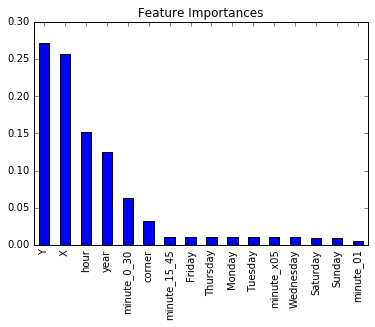

In [16]:
# очень важные признаки
feat_imp = pd.Series(rf_clf.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')

#### 4.5. Обучение финальной модели

In [ ]:
n_estimators = 500
max_depth = 18
random_state= 19

X = modify_features(train)

rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=4, 
                                random_state=random_state, verbose=True)

start_time = datetime.datetime.now()
rf_clf.fit(X, y)
duration = (datetime.datetime.now() - start_time).total_seconds()


print 'trees:', n_estimators
print 'Time elapsed:', duration
print 'max_depth:', rf_clf.get_params()['max_depth']

In [18]:
# очень большой размер модели, нафиг надо
clf = rf_clf
model_file = 'rf01.cpickle'

# save model
# with open(model_file, 'wb') as f:
#     cPickle.dump(clf, f)


# load model
# with open('path/to/file', 'rb') as f:
#     clf = cPickle.load(f)

### 5. Тестирование

In [19]:
filename = 'mysub.csv.gzip'

#### 5.1. Загрузка и обработка тестовой выборки

In [13]:
test = typify_origin(pd.read_csv('./data/test.csv'))
X_test = modify_features(test)
X_test.info()

train = 0
test = 0
X = 0
X_train = 0
# get local variables
# whos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884262 entries, 0 to 884261
Data columns (total 16 columns):
X               884262 non-null float64
Y               884262 non-null float64
year            884262 non-null int64
hour            884262 non-null int64
minute_0_30     884262 non-null int64
minute_15_45    884262 non-null int64
minute_01       884262 non-null int64
minute_x05      884262 non-null int64
corner          884262 non-null int64
Sunday          884262 non-null float64
Monday          884262 non-null float64
Tuesday         884262 non-null float64
Wednesday       884262 non-null float64
Thursday        884262 non-null float64
Friday          884262 non-null float64
Saturday        884262 non-null float64
dtypes: float64(9), int64(7)
memory usage: 114.7 MB


In [16]:
# whos

#### 5.2. Предсказания классификатора
Пропускаем тестовую выборку через свой классификатор и записываем результаты в файл. 

In [ ]:
y_pred = clf.predict_proba(X_test)

In [128]:
out = pd.DataFrame(data=y_pred, columns=out_features)
out.to_csv(filename, index_label='Id', float_format='%.6f')

# write_results(filename, pred)